# 0 Configuration

In [53]:
config = {
    "overview": {
        "overview_plot": False
    },
    "cleaning": {
        "emptyness": {
            "overview_plot": False
        },
        "categoricals": {
            "types": {
                "to_num": True
            },
            "inconsistencies": {
                "strip_and_lower": True
            }
        },
        "numericals": {
            "overview_plot": False,
            "outliers": {
                "remove": True,
                "plot": False,
                "big_remove": True,
                "big_remove_plot": True
            },
            "scaling": {
                "distrib_plot": False
            }
        }
    },
    "correlations": {
        "heatmap_pre_plot": False,
        "correlation_process": False,
        "heatmap_post_plot": False
    }
}

***
# 1 Dependency import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from fuzzywuzzy import process
import chardet

from math import ceil

from sklearn.preprocessing import minmax_scale

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

np.random.seed(0)

In [3]:
def dataframe_distribution_overview(data, figsize=(10, 3)):
    plt.figure(figsize=figsize)

    sns.barplot(x=data.columns, y=data.count())

    plt.title("Number of values per column", size=20)
    plt.xticks(rotation=45, size=16, ha="right")
    plt.yticks(size=16)
    plt.ylabel("Number values", size=16)
    plt.show()

In [4]:
def index_lth(data, percentage: int):
    percentage = percentage / 100
    less_than = data.count() < data.shape[0] * percentage
    index_less_than = less_than[less_than == True].index
    return index_less_than

In [5]:
def multi_plot_numerical(data, features, kind="hist", n_cols=8, figsize=(30, 10), wspace=0.35, hspace=0.35):
    feature_nb = len(features)
    n_rows = ceil(feature_nb / n_cols)
    index = 0

    plt.subplots(n_rows, n_cols, figsize=figsize)
    plt.subplots_adjust(wspace=wspace, hspace=hspace)

    for r in range(n_rows):
        for c in range(n_cols):
            if index >= feature_nb:
                break

            plt.subplot(n_rows, n_cols, index+1)

            feature = features[index]

            if kind == "box":
                plot = sns.boxplot(y=data[feature])
            elif kind == "hist":
                plot = sns.histplot(data=data[feature], kde=True)
            else:
                plot = sns.histplot(data=data[feature], kde=True)

            plot.set_xlabel(feature, fontsize=12)
            plot.set_ylabel(None)

            index += 1

    plt.show()

In [6]:
def create_subplot(dataset, feature, n_rows, index, is_numeric):
    plt.subplot(n_rows, 2, index)
    uniques = dataset[feature].unique()

    if is_numeric:
        plot = sns.boxplot(y=dataset[feature])
    else:
        if uniques.size <= 20 and uniques.size > 0:
            plot = sns.countplot(x=dataset[feature])
            plt.xticks(rotation=45, size=8, ha="right")
        else:
            dist = pd.DataFrame(data=[[uniques.size, dataset.shape[0] - uniques.size]], columns=["uniques", "not_uniques"])
            plot = sns.barplot(data=dist)

    plot.set_xlabel(None)
    plot.set_ylabel(feature, fontsize=14)


def dataset_diff_analysis(data1, data2, exclude=[], figsize=(15, 200)):
    features = data1.columns.union(data2.columns).difference(exclude)
    n_cols = 2
    n_rows = len(features)
    col_id = 0
    index = 1

    plt.subplots(n_rows, n_cols, figsize=figsize)
    plt.subplots_adjust(wspace=0.35, hspace=0.5)

    for f in features:
        is_numeric = False
        if f in data1.columns:
            f_type = data1[f].dtype
        else:
            f_type = data2[f].dtype
        if f_type in ["int64", "float64"]:
            is_numeric = True

        if f in data1.columns.values:
            create_subplot(data1, f, n_rows, index, is_numeric)
        if f in data2.columns.values:
            create_subplot(data2, f, n_rows, index+1, is_numeric)

        index += 2

    print(f"features: {features}")
    plt.show()

In [7]:
def decribe_several(feature, *df):
    data = {}
    index = 1
    for d in df:
        data[feature + "_" + str(index)] = d[feature]
        index += 1
    final_dataframe = pd.DataFrame(data)
    return final_dataframe.describe()

In [8]:
def head_several(feature, nb, *df):
    data = {}
    index = 1
    for d in df:
        data[feature + "_" + str(index)] = d[feature]
        index += 1
    final_dataframe = pd.DataFrame(data)
    return final_dataframe.head(nb)

In [86]:
class OutlierProcessor():
    def __init__(self, data, features, lower_trig, upper_trig):
        self.data = data
        self.features = features
        self.lower_trig = lower_trig
        self.upper_trig = upper_trig
        self.__above = 0
        self.__below = 0
        self.__total = 0

    def __print(self):
        print(f"lower_trig: {self.lower_trig}")
        print(f"upper_trig: {self.upper_trig}")
        print(f"below: {self.__below}")
        print(f"above: {self.__above}")
        print(f"total: {self.__total}")

    def analyse(self):
        self.__below = self.data[self.data[self.features] < self.lower_trig][self.features].count()
        self.__above = self.data[self.data[self.features] > self.upper_trig][self.features].count()
        self.__total = self.__below + self.__above
        self.__print()

    def replace(self, replace_by=np.nan, inplace=False):
        return self.data[self.features].where(cond=lambda x: ((x > self.lower_trig) & (self.upper_trig > x)), other=replace_by, inplace=inplace)


In [92]:
class OutlierIqrProcessor(OutlierProcessor):
    def __init__(self, data, features, exclude=None):
        self.features = [feature for feature in features if feature not in exclude]
        self.__q1 = data[self.features].quantile(0.25)
        self.__q3 = data[self.features].quantile(0.75)
        self.__iqr = self.__q3 - self.__q1
        upper_trig = self.__q3 + (1.5 * self.__iqr)
        lower_trig = self.__q1 - (1.5 * self.__iqr)
        super().__init__(data, self.features, lower_trig, upper_trig)


In [11]:
def correlation_heatmap(dataset, figsize=(30, 20)):
    plt.figure(figsize=figsize)

    correlation = dataset.corr()
    mask = np.triu(np.ones_like(correlation, dtype=bool))

    sns.heatmap(data=correlation, mask=mask, annot=True, vmax=.75, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.title("Correlation heatmap", size=20)
    plt.xticks(rotation=45, size=16, ha="right")
    plt.yticks(size=16)
    plt.show()

In [12]:
def unique_several(dataset, features, take=20):
    uniques_data = {}
    too_many_uniques = []
    only_one_uniques = []
    only_two_uniques = []

    for f in features:
        f_uniques = dataset[f].unique()
        if f_uniques.size <= take:
            if f_uniques.size == 1:
                only_one_uniques.append(f)
            elif f_uniques.size == 2:
                only_two_uniques.append(f)
            else:
                uniques_data[f] = pd.Series(data=f_uniques, name=f, dtype="object")
        else:
            too_many_uniques.append((f, f_uniques.size))

    print(f"Only one unique: {only_one_uniques}")
    print(f"Only two uniques: {only_two_uniques}")
    print(f"Too many uniques: {too_many_uniques}")

    return pd.DataFrame(data=uniques_data)

In [13]:
def strip_and_lower(dataset, features, to_strip=None, inplace=False):
    result_data = {}
    for f in features:
        result_data[f] = pd.Series(data=dataset[f].str.strip(to_strip=to_strip), name=f, dtype="object")
        result_data[f] = result_data[f].str.lower()
    result = pd.DataFrame(data=result_data)
    if inplace:
        dataset[features] = result
    else:
        return result

In [14]:
def fuzzy_matching_several(dataset, fuzzy, limit=10):
    fuzzy_data = {}
    for feature, match in fuzzy:
        fuzzy_matches = fuzzywuzzy.process.extract(match, dataset[feature], limit=limit, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
        fuzzy_data[feature] = pd.Series(data=fuzzy_matches, name=feature, dtype="object")
    return pd.DataFrame(data=fuzzy_data)

***
# 2 Data loading

In [15]:
data = pd.read_csv("data/2016-building-energy-benchmarking.csv", delimiter=",")

***
# 3 Overview

In [16]:
if config["overview"]["overview_plot"]:
    dataframe_distribution_overview(data, figsize=(30, 3))

***
# 4 Cleaning

***
## 4.1 Emptyness

In [17]:
cols_to_remove = index_lth(data, 10)

In [18]:
data.drop(columns=cols_to_remove, inplace=True)

In [19]:
if config["cleaning"]["emptyness"]["overview_plot"]:
    dataframe_distribution_overview(data, figsize=(30, 3))

***
## 4.2 Usefullness

In [20]:
data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,Compliant,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,Compliant,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,Compliant,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,Compliant,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,Compliant,505.01,2.88


In [21]:
data.describe(include="all")

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
count,3376.000000,3376.0,3376,3376,3376,3376,3376,3376,3360.000000,3376,3376.000000,3376,3376.000000,3376.000000,3376.000000,3368.000000,3376.000000,3.376000e+03,3376.000000,3.376000e+03,3367,3356,3.356000e+03,1679,1679.000000,596,596.000000,2533.000000,3369.000000,3370.000000,3367.000000,3367.000000,3.371000e+03,3.370000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3376,3376,3367.000000,3367.000000
unique,NaN,NaN,8,24,3362,3354,1,1,NaN,3268,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,466,56,NaN,50,NaN,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,4,NaN,NaN
top,NaN,NaN,NonResidential,Low-Rise Multifamily,Northgate Plaza,2600 SW Barton St,Seattle,WA,NaN,1625049001,NaN,DOWNTOWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Multifamily Housing,Multifamily Housing,NaN,Parking,NaN,Retail Store,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Compliant,NaN,NaN
freq,NaN,NaN,1460,987,3,4,3376,3376,NaN,8,NaN,573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,866,1667,NaN,976,NaN,110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3263,3211,NaN,NaN
mean,21208.991114,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,98116.949107,NaN,4.439277,NaN,47.624033,-122.334795,1968.573164,1.106888,4.709123,9.483354e+04,8001.526066,8.683201e+04,NaN,NaN,7.917764e+04,NaN,28444.075817,NaN,11738.675166,67.918674,54.732116,57.033798,134.232848,137.783932,5.403667e+06,5.276726e+06,2.745959e+05,1.086639e+06,3.707612e+06,1.368505e+04,1.368505e+06,NaN,NaN,119.723971,1.175916
std,12223.757015,0.0,NaN,NaN,NaN,NaN,NaN,NaN,18.615205,NaN,2.120625,NaN,0.047758,0.027203,33.088156,2.108402,5.494465,2.188376e+05,32326.723928,2.079398e+05,NaN,NaN,2.017034e+05,NaN,54392.917928,NaN,29331.199286,26.873271,56.273124,57.163330,139.287554,139.109807,2.161063e+07,1.593879e+07,3.912173e+06,4.352478e+06,1.485066e+07,6.709781e+04,6.709781e+06,NaN,NaN,538.832227,1.821452
min,1.000000,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,98006.000000,NaN,1.000000,NaN,47.499170,-122.414250,1900.000000,0.000000,0.000000,1.128500e+04,0.000000,3.636000e+03,NaN,NaN,5.656000e+03,NaN,0.000000,NaN,0.000000,1.000000,0.000000,0.000000,0.000000,-2.100000,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,NaN,NaN,-0.800000,-0.020000
25%,19990.750000,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,98105.000000,NaN,3.000000,NaN,47.599860,-122.350662,1948.000000,1.000000,2.000000,2.848700e+04,0.000000,2.775600e+04,NaN,NaN,2.509475e+04,NaN,5000.000000,NaN,2239.000000,53.000000,27.900000,29.400000,74.699997,78.400002,9.251286e+05,9.701822e+05,0.000000e+00,1.874229e+05,6.394870e+05,0.000000e+00,0.000000e+00,NaN,NaN,9.495000,0.210000
50%,23112.000000,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,98115.000000,NaN,4.000000,NaN,47.618675,-122.332495,1975.000000,1.000000,4.000000,4.417500e+04,0.000000,4.321600e+04,NaN,NaN,3.989400e+04,NaN,10664.000000,NaN,5043.000000,75.000000,38.599998,40.900002,96.199997,101.099998,1.803753e+06,1.904452e+06,0.000000e+00,3.451299e+05,1.177583e+06,3.237538e+03,3.237540e+05,NaN,NaN,33.920000,0.610000
75%,25994.250000,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,98122.000000,NaN,7.000000,NaN,47.657115,-122.319407,1997.000000,1.000000,5.000000,9.099200e+04,0.000000,8.427625e+04,NaN,NaN,7.620025e+04,NaN,26640.000000,NaN,10138.750000,90.000000,60.400002,

In [97]:
data.drop(columns="DataYear", inplace=True)

***
## 4.3 Categoricals

### 4.2.1 Overview

In [22]:
categorical_data = data.select_dtypes("object")
categorical_data.describe()

,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,TaxParcelIdentificationNumber,Neighborhood,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ComplianceStatus
count,3376,3376,3376,3376,3376,3376,3376,3376,3367,3356,1679,596,3376
unique,8,24,3362,3354,1,1,3268,19,466,56,50,44,4
top,NonResidential,Low-Rise Multifamily,Northgate Plaza,2600 SW Barton St,Seattle,WA,1625049001,DOWNTOWN,Multifamily Housing,Multifamily Housing,Parking,Retail Store,Compliant
freq,1460,987,3,4,3376,3376,8,573,866,1667,976,110,3211


In [23]:
categorical_data.head()

,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,TaxParcelIdentificationNumber,Neighborhood,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ComplianceStatus
0,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,0659000030,DOWNTOWN,Hotel,Hotel,NaN,NaN,Compliant
1,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,0659000220,DOWNTOWN,"Hotel, Parking, Restaurant",Hotel,Parking,Restaurant,Compliant
2,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,0659000475,DOWNTOWN,Hotel,Hotel,NaN,NaN,Compliant
3,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,0659000640,DOWNTOWN,Hotel,Hotel,NaN,NaN,Compliant
4,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,0659000970,DOWNTOWN,"Hotel, Parking, Swimming Pool",Hotel,Parking,Swimming Pool,Compliant


***
### 4.2.2 Types

feature "TaxParcelIdentificationNumber" is supposed to be a numeric type but a value force pandas to make it 'object'.  
It must be parsed and each conversion error will lead to convert the value to NaN

In [24]:
data["TaxParcelIdentificationNumber"].describe()

count           3376
unique          3268
top       1625049001
freq               8
Name: TaxParcelIdentificationNumber, dtype: object

In [25]:
if config["cleaning"]["categoricals"]["types"]["to_num"]:
    data["TaxParcelIdentificationNumber"] = pd.to_numeric(data["TaxParcelIdentificationNumber"], errors="coerce")

In [26]:
data["TaxParcelIdentificationNumber"].describe()

count    3.373000e+03
mean     4.297012e+09
std      2.960847e+09
min      0.000000e+00
25%      1.975701e+09
50%      3.524039e+09
75%      7.129302e+09
max      5.569640e+10
Name: TaxParcelIdentificationNumber, dtype: float64

feature "DefaultData_2015" can be seen as a 'bool' type.  
First: replace all the 'No' and 'Yes' by real boolean values  
Second: make sure the feature is now 'bool' type

In [27]:
data["DefaultData"].unique()

array([False,  True])

In [28]:
data["DefaultData"].dtype

dtype('bool')

Now some features has been converted to other type than 'object', we must reevaluate or categorical_data

In [29]:
categorical_data = data.select_dtypes("object")

***
### 4.2.3 Inconsistencies

In [30]:
unique_several(data, categorical_data.columns.values, take=50)

Only one unique: ['City', 'State']
Only two uniques: []
Too many uniques: [('PropertyName', 3362), ('Address', 3354), ('ListOfAllPropertyUseTypes', 467), ('LargestPropertyUseType', 57), ('SecondLargestPropertyUseType', 51)]


,BuildingType,PrimaryPropertyType,Neighborhood,ThirdLargestPropertyUseType,ComplianceStatus
0,NonResidential,Hotel,DOWNTOWN,NaN,Compliant
1,Nonresidential COS,Other,SOUTHEAST,Restaurant,Error - Correct Default Data
2,Multifamily MR (5-9),Mid-Rise Multifamily,NORTHEAST,Swimming Pool,Missing Data
3,SPS-District K-12,Mixed Use Property,EAST,Data Center,Non-Compliant
4,Campus,K-12 School,Central,Office,NaN
5,Multifamily LR (1-4),University,NORTH,Retail Store,NaN
6,Multifamily HR (10+),Small- and Mid-Sized Office,MAGNOLIA / QUEEN ANNE,Other - Entertainment/Public Assembly,NaN
7,Nonresidential WA,Self-Storage Facility,LAKE UNION,Non-Refrigerated Warehouse,NaN
8,NaN,Warehouse,GREATER DUWAMISH,Other,NaN
9,NaN,Large Office,BALLARD,Distribution Center,NaN


In [31]:
if config["cleaning"]["categoricals"]["inconsistencies"]["strip_and_lower"]:
    strip_and_lower(data, categorical_data.columns.values, inplace=True)

In [32]:
unique_several(data, categorical_data.columns.values, take=50)

Only one unique: ['City', 'State']
Only two uniques: []
Too many uniques: [('PropertyName', 3360), ('Address', 3353), ('ListOfAllPropertyUseTypes', 467), ('LargestPropertyUseType', 57), ('SecondLargestPropertyUseType', 51)]


,BuildingType,PrimaryPropertyType,Neighborhood,ThirdLargestPropertyUseType,ComplianceStatus
0,nonresidential,hotel,downtown,NaN,compliant
1,nonresidential cos,other,southeast,restaurant,error - correct default data
2,multifamily mr (5-9),mid-rise multifamily,northeast,swimming pool,missing data
3,sps-district k-12,mixed use property,east,data center,non-compliant
4,campus,k-12 school,central,office,NaN
5,multifamily lr (1-4),university,north,retail store,NaN
6,multifamily hr (10+),small- and mid-sized office,magnolia / queen anne,other - entertainment/public assembly,NaN
7,nonresidential wa,self-storage facility,lake union,non-refrigerated warehouse,NaN
8,NaN,warehouse,greater duwamish,other,NaN
9,NaN,large office,ballard,distribution center,NaN


In [33]:
# fuzzy = [
#     ("Neighborhood_2016", "Ballard"),
# ]
# fuzzy_matching_several(data)

***
## 4.4 Numericals

### 4.3.1 Overview

In [99]:
numerical_data = data.select_dtypes(["int64", "float64"])

In [35]:
if config["cleaning"]["numericals"]["overview_plot"]:
    multi_plot_numerical(data, numerical_data.columns.values, kind="box", n_cols=6, hspace=0.4, wspace=0.30, figsize=(30, 25))

***
### 4.3.2 Outliers removal

In [36]:
values = data[numerical_data.columns.values].idxmax().value_counts()
# values

In [37]:
data[numerical_data.columns.values].describe()

,OSEBuildingID,DataYear,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,3376.000000,3376.0,3360.000000,3.373000e+03,3376.000000,3376.000000,3376.000000,3376.000000,3368.000000,3376.000000,3.376000e+03,3376.000000,3.376000e+03,3.356000e+03,1679.000000,596.000000,2533.000000,3369.000000,3370.000000,3367.000000,3367.000000,3.371000e+03,3.370000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3367.000000,3367.000000
mean,21208.991114,2016.0,98116.949107,4.297012e+09,4.439277,47.624033,-122.334795,1968.573164,1.106888,4.709123,9.483354e+04,8001.526066,8.683201e+04,7.917764e+04,28444.075817,11738.675166,67.918674,54.732116,57.033798,134.232848,137.783932,5.403667e+06,5.276726e+06,2.745959e+05,1.086639e+06,3.707612e+06,1.368505e+04,1.368505e+06,119.723971,1.175916
std,12223.757015,0.0,18.615205,2.960847e+09,2.120625,0.047758,0.027203,33.088156,2.108402,5.494465,2.188376e+05,32326.723928,2.079398e+05,2.017034e+05,54392.917928,29331.199286,26.873271,56.273124,57.163330,139.287554,139.109807,2.161063e+07,1.593879e+07,3.912173e+06,4.352478e+06,1.485066e+07,6.709781e+04,6.709781e+06,538.832227,1.821452
min,1.000000,2016.0,98006.000000,0.000000e+00,1.000000,47.499170,-122.414250,1900.000000,0.000000,0.000000,1.128500e+04,0.000000,3.636000e+03,5.656000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-2.100000,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,-0.800000,-0.020000
25%,19990.750000,2016.0,98105.000000,1.975701e+09,3.000000,47.599860,-122.350662,1948.000000,1.000000,2.000000,2.848700e+04,0.000000,2.775600e+04,2.509475e+04,5000.000000,2239.000000,53.000000,27.900000,29.400000,74.699997,78.400002,9.251286e+05,9.701822e+05,0.000000e+00,1.874229e+05,6.394870e+05,0.000000e+00,0.000000e+00,9.495000,0.210000
50%,23112.000000,2016.0,98115.000000,3.524039e+09,4.000000,47.618675,-122.332495,1975.000000,1.000000,4.000000,4.417500e+04,0.000000,4.321600e+04,3.989400e+04,10664.000000,5043.000000,75.000000,38.599998,40.900002,96.199997,101.099998,1.803753e+06,1.904452e+06,0.000000e+00,3.451299e+05,1.177583e+06,3.237538e+03,3.237540e+05,33.920000,0.610000
75%,25994.250000,2016.0,98122.000000,7.129302e+09,7.000000,47.657115,-122.319407,1997.000000,1.000000,5.000000,9.099200e+04,0.000000,8.427625e+04,7.620025e+04,26640.000000,10138.750000,90.000000,60.400002,64.275002,143.899994,148.349998,4.222455e+06,4.381429e+06,0.000000e+00,8.293178e+05,2.829632e+06,1.189033e+04,1.189034e+06,93.940000,1.370000
max,50226.000000,2016.0,98272.000000,5.569640e+10,7.000000,47.733870,-122.220966,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,686750.000000,459748.000000,100.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,16870.980000,34.090000


In [38]:
data.loc[values[values > 3].index]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
3274,49967,2016,campus,university,university of washington - seattle campus,ne 45th st & brooklyn ave,seattle,wa,98105.0,1.625049e+09,4,northeast,47.65644,-122.31041,1900,111.0,0,9320156,0,9320156,college/university,college/university,9320156.0,NaN,NaN,NaN,NaN,NaN,93.800003,0.000000,246.600006,0.000000,873923712.0,0.0,84985240.0,192577488.0,657074389.0,0.0,0.0,False,compliant,11140.56,1.20
35,43,2016,campus,mixed use property,plant 2 site,7755 e marginal way s,seattle,wa,98108.0,2.200000e+07,2,greater duwamish,47.53493,-122.31788,1992,1.0,3,494835,0,494835,"energy/power station, laboratory, manufacturin...",office,757027.0,laboratory,639931.0,non-refrigerated warehouse,459748.0,8.0,221.699997,233.100006,388.200012,400.299988,448385312.0,471613856.0,0.0,44102076.0,150476283.0,2979090.0,297909000.0,False,compliant,16870.98,34.09
240,365,2016,nonresidential,other,uw tower data center,4333 brooklyn ave ne,seattle,wa,98185.0,1.142000e+09,4,northeast,47.66060,-122.31512,1969,1.0,5,36000,0,36000,data center,data center,36000.0,NaN,NaN,NaN,NaN,96.0,834.400024,834.400024,2620.000000,2620.000000,30038490.0,30038490.0,0.0,8803777.0,30038487.0,0.0,0.0,False,compliant,209.41,5.82


In [39]:
if config["cleaning"]["numericals"]["outliers"]["remove"]:
    data.drop(index=values[values > 3].index, inplace=True)

In [40]:
if config["cleaning"]["numericals"]["outliers"]["plot"]:
    multi_plot_numerical(data, numerical_data.columns.values, kind="box", n_cols=6, hspace=0.4, wspace=0.30, figsize=(30, 25))

In [100]:
if config["cleaning"]["numericals"]["outliers"]["big_remove"]:
    o_proc = OutlierIqrProcessor(data, numerical_data.columns.values, exclude=["Latitude", "Longitude"])
    data_temp = o_proc.replace()


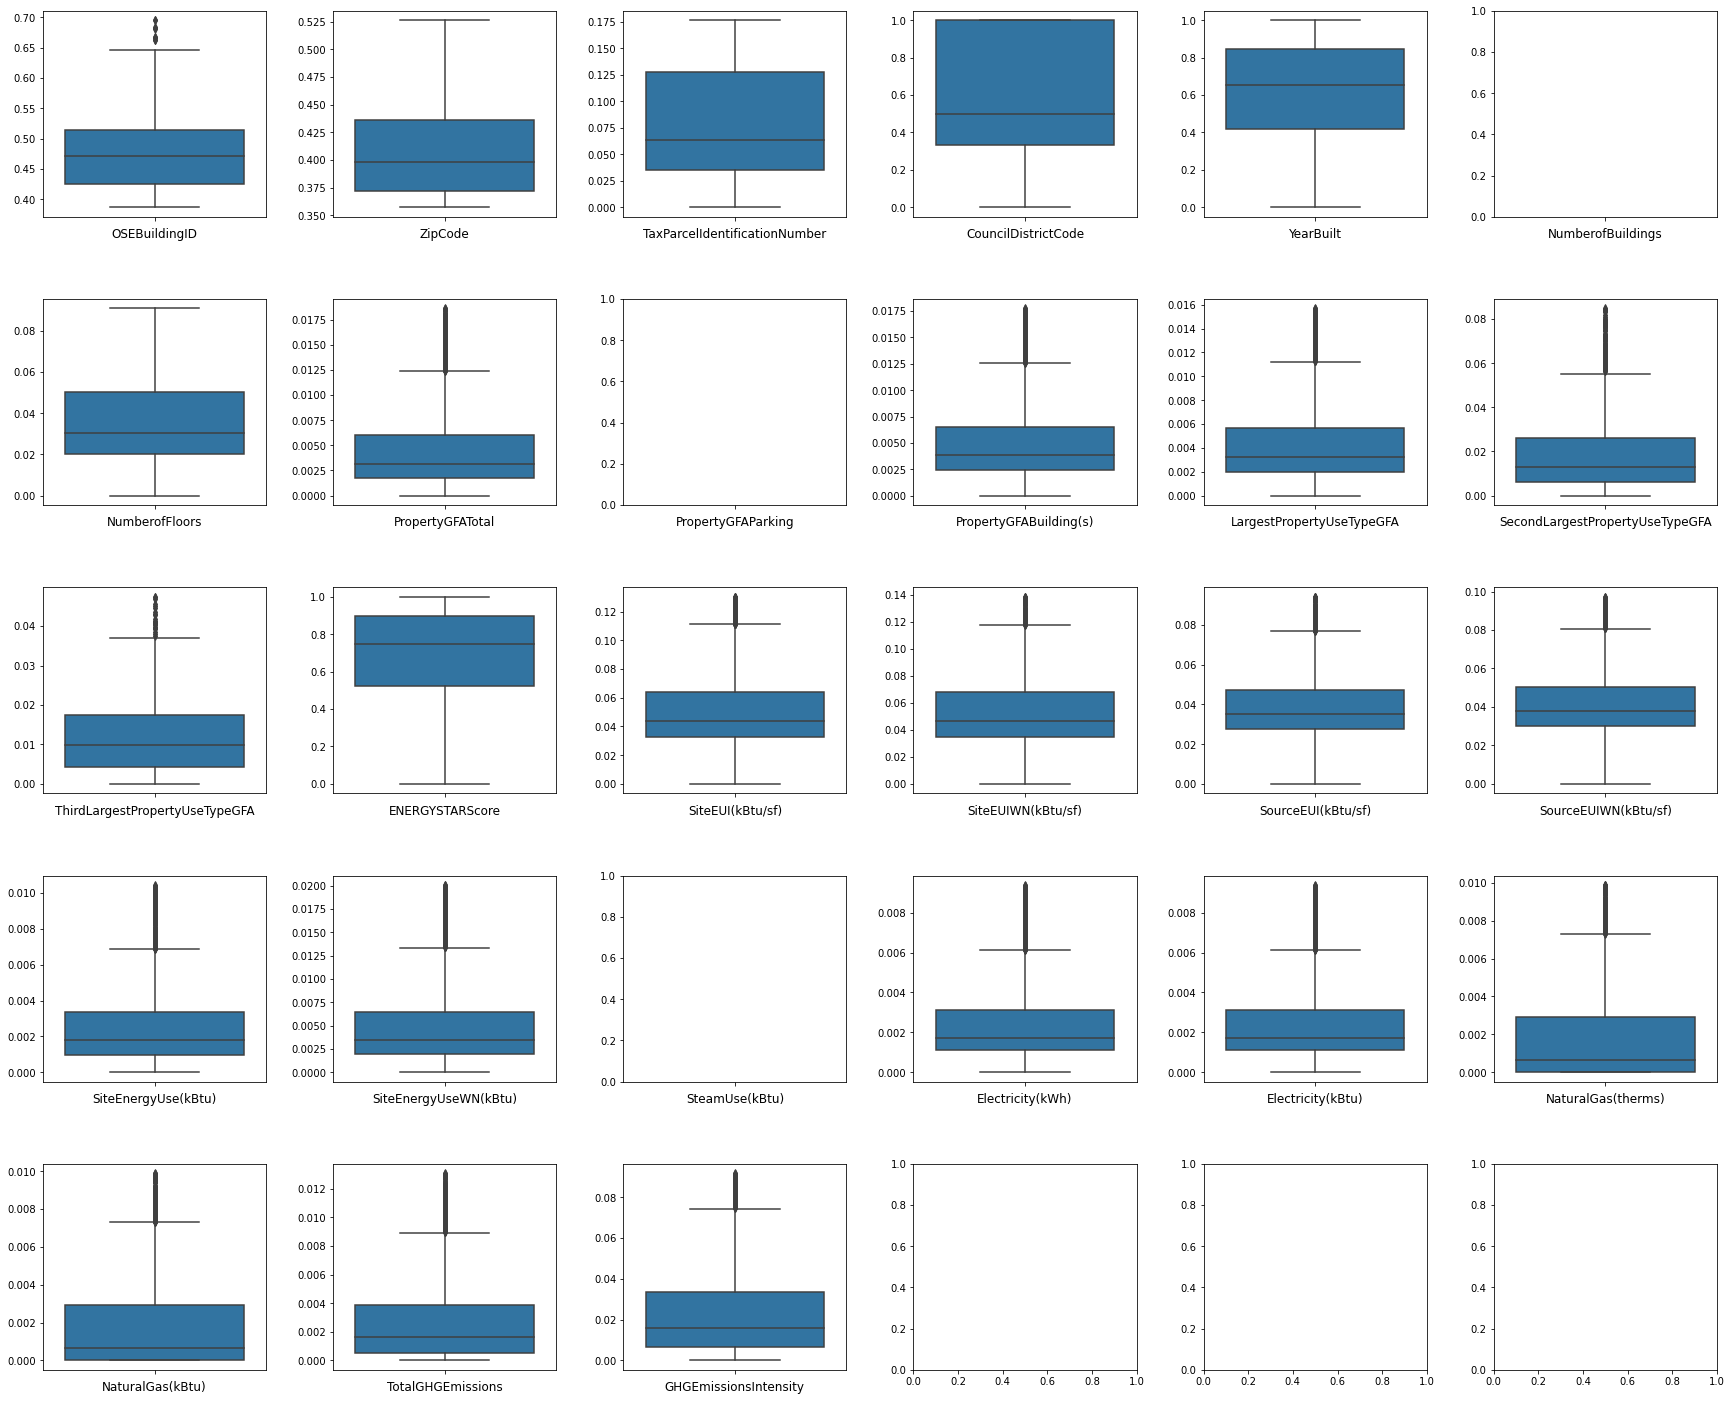

In [101]:
if config["cleaning"]["numericals"]["outliers"]["big_remove_plot"]:
    multi_plot_numerical(data_temp, data_temp.columns, kind="box", n_cols=6, hspace=0.4, wspace=0.30, figsize=(30, 25))

***
### 4.3.3 Scaling

In [41]:
if config["cleaning"]["numericals"]["scaling"]["distrib_plot"]:
    multi_plot_numerical(data, numerical_data.columns.values, n_cols=5, hspace=0.4, wspace=0.2, figsize=(30, 50))

In [42]:
data[numerical_data.columns] = pd.DataFrame(data=minmax_scale(numerical_data), columns=numerical_data.columns)
data[numerical_data.columns].head()

,OSEBuildingID,DataYear,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
0,0.000000,0.0,0.357143,0.011832,1.0,0.481594,0.394549,0.234783,0.009009,0.121212,0.008288,0.000000,0.009102,0.008887,NaN,NaN,0.595960,0.097915,0.101031,0.069656,0.072881,0.008269,0.015811,0.014850,0.006180,0.006180,0.004285,0.004285,0.014864,0.083553
1,0.000020,0.0,0.357143,0.011832,1.0,0.485726,0.415554,0.834783,0.009009,0.111111,0.009913,0.029387,0.009109,0.008398,0.021935,0.010053,0.606061,0.113615,0.117330,0.067214,0.069219,0.009598,0.018372,0.000000,0.005110,0.005110,0.017271,0.017271,0.017583,0.084433
2,0.000040,0.0,0.357143,0.011832,1.0,0.488965,0.393980,0.600000,0.009009,0.414141,0.101497,0.383759,0.081120,0.080609,NaN,NaN,0.424242,0.115053,0.117090,0.092328,0.093894,0.083059,0.156775,0.159819,0.075537,0.075537,0.005014,0.005014,0.123880,0.064790
3,0.000080,0.0,0.357143,0.011832,1.0,0.489774,0.401533,0.226087,0.009009,0.101010,0.005375,0.000000,0.006192,0.005976,NaN,NaN,0.555556,0.132790,0.135786,0.082519,0.086229,0.007775,0.014730,0.016410,0.004389,0.004389,0.006080,0.006080,0.017024,0.137496
4,0.000139,0.0,0.432331,0.011832,1.0,0.488198,0.381718,0.695652,0.009009,0.181818,0.017649,0.120950,0.011801,0.012646,0.099030,0.000000,0.747475,0.137584,0.142258,0.080687,0.083025,0.016217,0.031077,0.000000,0.008345,0.008345,0.029553,0.029553,0.029980,0.085019


In [43]:
data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
0,0.000000,0.0,nonresidential,hotel,mayflower park hotel,405 olive way,seattle,wa,0.357143,0.011832,1.0,downtown,0.481594,0.394549,0.234783,0.009009,0.121212,0.008288,0.000000,0.009102,hotel,hotel,0.008887,NaN,NaN,NaN,NaN,0.595960,0.097915,0.101031,0.069656,0.072881,0.008269,0.015811,0.014850,0.006180,0.006180,0.004285,0.004285,False,compliant,0.014864,0.083553
1,0.000020,0.0,nonresidential,hotel,paramount hotel,724 pine street,seattle,wa,0.357143,0.011832,1.0,downtown,0.485726,0.415554,0.834783,0.009009,0.111111,0.009913,0.029387,0.009109,"hotel, parking, restaurant",hotel,0.008398,parking,0.021935,restaurant,0.010053,0.606061,0.113615,0.117330,0.067214,0.069219,0.009598,0.018372,0.000000,0.005110,0.005110,0.017271,0.017271,False,compliant,0.017583,0.084433
2,0.000040,0.0,nonresidential,hotel,5673-the westin seattle,1900 5th avenue,seattle,wa,0.357143,0.011832,1.0,downtown,0.488965,0.393980,0.600000,0.009009,0.414141,0.101497,0.383759,0.081120,hotel,hotel,0.080609,NaN,NaN,NaN,NaN,0.424242,0.115053,0.117090,0.092328,0.093894,0.083059,0.156775,0.159819,0.075537,0.075537,0.005014,0.005014,False,compliant,0.123880,0.064790
3,0.000080,0.0,nonresidential,hotel,hotel max,620 stewart st,seattle,wa,0.357143,0.011832,1.0,downtown,0.489774,0.401533,0.226087,0.009009,0.101010,0.005375,0.000000,0.006192,hotel,hotel,0.005976,NaN,NaN,NaN,NaN,0.555556,0.132790,0.135786,0.082519,0.086229,0.007775,0.014730,0.016410,0.004389,0.004389,0.006080,0.006080,False,compliant,0.017024,0.137496
4,0.000139,0.0,nonresidential,hotel,warwick seattle hotel (id8),401 lenora st,seattle,wa,0.432331,0.011832,1.0,downtown,0.488198,0.381718,0.695652,0.009009,0.181818,0.017649,0.120950,0.011801,"hotel, parking, swimming pool",hotel,0.012646,parking,0.099030,swimming pool,0.000000,0.747475,0.137584,0.142258,0.080687,0.083025,0.016217,0.031077,0.000000,0.008345,0.008345,0.029553,0.029553,False,compliant,0.029980,0.085019


In [44]:
if config["cleaning"]["numericals"]["scaling"]["distrib_plot"]:
    multi_plot_numerical(data, numerical_data.columns.values, n_cols=5, hspace=0.4, wspace=0.2, figsize=(30, 50))

***
## 4.5 Target

In [45]:
target = "SiteEnergyUse(kBtu)"

In [46]:
data[target].isna().any()

True

In [47]:
data.dropna(subset=[target], inplace=True)

In [48]:
data[target].isna().any()

False

***
# 5 Correlations

In [49]:
if config["correlations"]["heatmap_pre_plot"]:
    correlation_heatmap(data)

In [50]:
def categorize(feature):
    new_feature = feature.astype("category").cat.codes
    return new_feature

if config["correlations"]["correlation_process"]:
    categs = data.select_dtypes(include="object")
    categs_to_nums = categs.apply(lambda col: categorize(col))

    for col in categs_to_nums.columns:
        categs_to_nums.rename(columns={col: col + "_CATEG"}, inplace=True)

    data_enhanced = data.join([categs_to_nums])

In [51]:
if config["correlations"]["heatmap_post_plot"]:
    correlation_heatmap(data_enhanced)

***
# 6 Saving

In [52]:
data.to_csv("data/data-cleaned.csv", sep=",")